In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
from sklearn import preprocessing
from pathlib import Path
from PIL import Image

In [2]:
symbols_list = ['zero','one','two','three','four','five','six','seven','eight','nine','minus','plus','equal','div','decimal','times']
dataset_path = "../input/handwritten-math-symbol-dataset/train"
train_image = []
train_label = []

for symbols_dir in os.listdir(dataset_path):
    if symbols_dir.split()[0] in symbols_list:
        for image in os.listdir(dataset_path + "/" + symbols_dir):
            train_label.append(symbols_dir.split()[0])
            train_image.append(dataset_path + "/" + symbols_dir + "/" + image)

In [3]:
eval_path = "../input/handwritten-math-symbol-dataset/eval"
test_image = []
test_label = []

for symbols_dir in os.listdir(eval_path):
    if symbols_dir.split()[0] in symbols_list:
        for image in os.listdir(eval_path + "/" + symbols_dir):
            test_label.append(symbols_dir.split()[0])
            test_image.append(eval_path + "/" + symbols_dir + "/" + image)

In [4]:
print("Length of train_image : " , len(train_image) , " , length of labels list : " ,len(train_label))
print("Length of test_image : " , len(test_image) , " , length of labels list : " ,len(test_label))

Length of train_image :  7557  , length of labels list :  7557
Length of test_image :  1010  , length of labels list :  1010


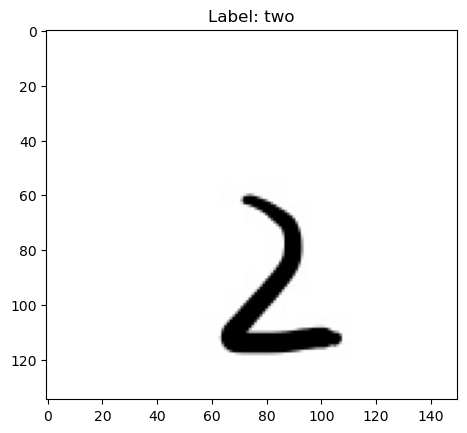

In [5]:
image = cv2.imread(train_image[140])
plt.imshow(image)
plt.title("Label: " + train_label[140])
plt.show()

In [6]:
image.shape

(135, 150, 3)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=10,
                                   data_format='channels_last',
                                   validation_split = 0.2) 

test_datagen = ImageDataGenerator(rescale=1./255,
                                  data_format='channels_last')

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(100, 100),
    color_mode = "rgb",
    shuffle = True,
    batch_size = 48,
    classes = symbols_list,
    subset = 'training') 

valid_generator = train_datagen.flow_from_directory(
    dataset_path, 
    target_size=(100, 100),
    color_mode = "rgb",
    shuffle = True,
    batch_size = 48,
    classes = symbols_list,
    subset = 'validation') 

test_generator = test_datagen.flow_from_directory(
    eval_path, 
    target_size=(100, 100),
    color_mode = "rgb",
    shuffle = True,
    batch_size = 48,
    classes = symbols_list) 

Found 5616 images belonging to 16 classes.
Found 1396 images belonging to 16 classes.
Found 538 images belonging to 16 classes.


In [8]:
img ,label = train_generator.next()
print(img.shape)
print(label.shape)

(48, 100, 100, 3)
(48, 16)


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import LearningRateScheduler

input_shape = (48, 100, 100, 3)

model = Sequential()
model.add(Conv2D(48,kernel_size=3,strides=(2,2),activation='relu',input_shape=input_shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(96,kernel_size=3,strides=(2,2),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96,kernel_size=3,strides=(2,2),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(192,kernel_size=3,strides=(2,2),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(480,kernel_size=3,strides=(2,2),activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(16,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 49, 49, 48)        1344      
                                                                 
 batch_normalization (BatchN  (None, 49, 49, 48)       192       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 96)        41568     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 96)       384       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 96)        83040     
                                                                 
 batch_normalization_2 (Batc  (None, 12, 12, 96)       3

In [10]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

model.compile(optimizer='adam',loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=80,
          validation_data=test_generator,
          validation_steps = len(test_generator),
          callbacks=[annealer], 
          verbose=1)

Epoch 1/80
117/117 [==============================] - 59s 422ms/step - loss: 1.6912 - accuracy: 0.5621 - val_loss: 4.1730 - val_accuracy: 0.1022 - lr: 0.0010
Epoch 2/80
117/117 [==============================] - 21s 178ms/step - loss: 0.6653 - accuracy: 0.7965 - val_loss: 5.6762 - val_accuracy: 0.0093 - lr: 9.5000e-04
Epoch 3/80
117/117 [==============================] - 21s 178ms/step - loss: 0.4893 - accuracy: 0.8476 - val_loss: 1.6288 - val_accuracy: 0.4071 - lr: 9.0250e-04
Epoch 4/80
117/117 [==============================] - 21s 181ms/step - loss: 0.3423 - accuracy: 0.8944 - val_loss: 5.9633 - val_accuracy: 0.2379 - lr: 8.5737e-04
Epoch 5/80
117/117 [==============================] - 21s 180ms/step - loss: 0.3021 - accuracy: 0.9078 - val_loss: 2.7275 - val_accuracy: 0.4071 - lr: 8.1451e-04
Epoch 6/80
117/117 [==============================] - 22s 185ms/step - loss: 0.2342 - accuracy: 0.9281 - val_loss: 3.7139 - val_accuracy: 0.3959 - lr: 7.7378e-04
Epoch 7/80
117/117 [============

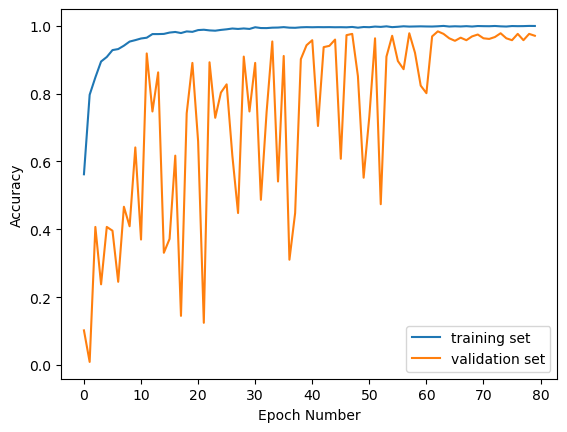

In [11]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='validation set')
plt.legend()

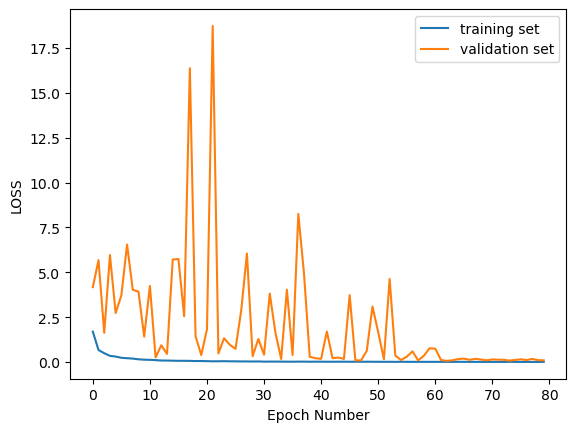

In [12]:
plt.xlabel('Epoch Number')
plt.ylabel('LOSS')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='validation set')
plt.legend()

In [13]:
model.evaluate(train_generator)

117/117 [==============================] - 19s 163ms/step - loss: 0.0904 - accuracy: 0.9653


[0.09035711735486984, 0.9652777910232544]

In [14]:
model.evaluate(test_generator)

12/12 [==============================] - 1s 53ms/step - loss: 0.0919 - accuracy: 0.9703


[0.09193087369203568, 0.9702602028846741]

In [15]:
model.save('model.h5',save_format='h5')